<a href="https://colab.research.google.com/github/siamislam1603/Soft-Computing-Lab/blob/master/Deep%20Neural%20Network/170104124_exp_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import os
import cv2
%matplotlib inline

### Run From the **`Hyperparameters for DNN`** cell to skip the preprocessing steps as the preprocessed data is saved to the drive after being preprocessed.

### Unzip the dataset to drive

In [ ]:
!unzip '/content/drive/MyDrive/Soft Computing Lab/Dataset A.zip' -d '/content/drive/MyDrive/Soft Computing Lab'

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/Soft Computing Lab/training-a/a14702.png  
  inflating: /content/drive/MyDrive/Soft Computing Lab/training-a/a14703.png  
  inflating: /content/drive/MyDrive/Soft Computing Lab/training-a/a14704.png  
  inflating: /content/drive/MyDrive/Soft Computing Lab/training-a/a14705.png  
  inflating: /content/drive/MyDrive/Soft Computing Lab/training-a/a14706.png  
  inflating: /content/drive/MyDrive/Soft Computing Lab/training-a/a14707.png  
  inflating: /content/drive/MyDrive/Soft Computing Lab/training-a/a14708.png  
  inflating: /content/drive/MyDrive/Soft Computing Lab/training-a/a14709.png  
  inflating: /content/drive/MyDrive/Soft Computing Lab/training-a/a14710.png  
  inflating: /content/drive/MyDrive/Soft Computing Lab/training-a/a14711.png  
  inflating: /content/drive/MyDrive/Soft Computing Lab/training-a/a14712.png  
  inflating: /content/drive/MyDrive/Soft Computing Lab/training-a/a14713.png  
 

### Read the csv file and dropped columns except `filename` & `digit`

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Soft Computing Lab/training-a.csv')
df=df[['filename','digit']]
img_dir='/content/drive/MyDrive/Soft Computing Lab/training-a/'
df['filename']=img_dir+df['filename']
df.head()

,filename,digit
0,/content/drive/MyDrive/Soft Computing Lab/trai...,5
1,/content/drive/MyDrive/Soft Computing Lab/trai...,3
2,/content/drive/MyDrive/Soft Computing Lab/trai...,1
3,/content/drive/MyDrive/Soft Computing Lab/trai...,7
4,/content/drive/MyDrive/Soft Computing Lab/trai...,0


In [ ]:
df['digit'].value_counts()

2    1984
6    1983
4    1982
3    1976
0    1975
5    1965
9    1964
1    1963
7    1960
8    1950
Name: digit, dtype: int64

### Splitting the dataset into train and test set

In [ ]:
X=df['filename']
y=df['digit']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

### Images are converted to grayscale, resized to 28X28 and normalized

In [ ]:
REBUILD_DATA=True
class Digits():
  IMG_SIZE=28
  training_data=[]
  testing_data=[]
  def make_data(self,feat,labels,data_type):
    for img_path,label in list(zip(feat,labels)):
      img=cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
      img=torch.tensor([cv2.resize(img,(self.IMG_SIZE,self.IMG_SIZE))])/255.
      if data_type=='train':
        self.training_data.append((img,label))
      elif data_type=='test':
        self.testing_data.append((img,label))

if REBUILD_DATA:
  digits=Digits()
  digits.make_data(X_train.values,y_train.values,'train')
  digits.make_data(X_test.values,y_test.values,'test')

### Saving training and test set to drive

In [ ]:
torch.save(digits.training_data, '/content/drive/MyDrive/Soft Computing Lab/training_set_a.pt')
torch.save(digits.testing_data, '/content/drive/MyDrive/Soft Computing Lab/testing_set_a.pt')

torch.Size([1, 28, 28])


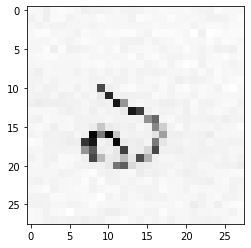

In [ ]:
print(digits.training_data[0][0].shape)
plt.imshow(digits.training_data[0][0][0],cmap='gray')

### Hyperparameters for DNN

In [ ]:
batch_size = 20
num_iters = 20000
input_dim = 28*28
num_hidden = 200
output_dim = 10

learning_rate = 0.01

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Six Layer FNN with ReLU Activation

In [ ]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        self.linear_1 = nn.Linear(input_size, num_hidden)
        self.relu_1 = nn.ReLU()
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        self.relu_2 = nn.ReLU()
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        self.relu_3 = nn.ReLU()
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        self.relu_4 = nn.ReLU()
        self.linear_5 = nn.Linear(num_hidden, num_hidden)
        self.relu_5 = nn.ReLU()
        self.linear_6 = nn.Linear(num_hidden, num_hidden)
        self.relu_6 = nn.ReLU()
        self.linear_out = nn.Linear(num_hidden, num_classes)

    def forward(self, x):
        out  = self.linear_1(x)
        out = self.relu_1(out)
        out  = self.linear_2(out)
        out = self.relu_2(out)
        out  = self.linear_3(out)
        out = self.relu_3(out)
        out  = self.linear_4(out)
        out = self.relu_4(out)
        out  = self.linear_5(out)
        out = self.relu_5(out)
        out  = self.linear_6(out)
        out = self.relu_6(out)
        probas  = self.linear_out(out)
        return probas

In [ ]:
def cal_accuracy(applied_model,ds_test_loader):
  correct = 0
  total = 0
  for images, labels in ds_test_loader:
    images = images.view(-1, 28*28).to(device)
    outputs = applied_model(images)
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    if torch.cuda.is_available():
        correct += (predicted.cpu() == labels.cpu()).sum() 
    else:
        correct += (predicted == labels).sum()

  accuracy = 100 * correct.item() / total
  return accuracy

In [ ]:
def evaluate_model(applied_model,ds_train_loader,ds_test_loader,num_epochs):
  iter_loss=[]
  iter=0
  for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    for i, (images, labels) in enumerate(ds_train_loader):
      images = images.view(-1, 28*28).to(device)
      labels = labels.to(device)
      optimizer.zero_grad()
      outputs = applied_model(images) 
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      if iter % 100 == 0:
        accuracy=cal_accuracy(applied_model,ds_test_loader)
        print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))
        iter_loss.append(loss.item())
      iter=iter+1
  return iter_loss

### Loading preprocessed training and test set of `Dataset-A` from drive

In [ ]:
train_set_ds1=torch.load('/content/drive/MyDrive/Soft Computing Lab/training_set_a.pt')
test_set_ds1=torch.load('/content/drive/MyDrive/Soft Computing Lab/testing_set_a.pt')
train_set_ds1[0][0].shape,test_set_ds1[0][0].shape

(torch.Size([1, 28, 28]), torch.Size([1, 28, 28]))

### Model Evaluation on `Dataset 1`

In [ ]:
g = torch.Generator()
g.manual_seed(42)
model_ds1 = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = num_hidden)
model_ds1.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_ds1.parameters(), lr=learning_rate)

train_loader_ds1 = torch.utils.data.DataLoader(dataset=train_set_ds1, 
                                           batch_size=batch_size, 
                                           shuffle=True,
                                           generator=g)

test_loader_ds1 = torch.utils.data.DataLoader(dataset=test_set_ds1, 
                                          batch_size=batch_size, 
                                          shuffle=False)

num_epochs_ds1 = num_iters / (len(train_set_ds1) / batch_size)
num_epochs_ds1 = int(num_epochs_ds1)
iter_loss_ds1=evaluate_model(model_ds1,train_loader_ds1,test_loader_ds1,num_epochs_ds1)

Epoch 1
-------------------------------
Iteration: 0. Loss: 2.303750514984131. Accuracy: 10.301953818827709
Iteration: 100. Loss: 2.295727252960205. Accuracy: 9.261608728749048
Iteration: 200. Loss: 2.2803025245666504. Accuracy: 10.504947982745495
Iteration: 300. Loss: 2.3210701942443848. Accuracy: 9.083988835320984
Iteration: 400. Loss: 2.3069138526916504. Accuracy: 9.515351433646282
Iteration: 500. Loss: 2.293156147003174. Accuracy: 10.707942146663283
Iteration: 600. Loss: 2.2837095260620117. Accuracy: 10.022836843440752
Iteration: 700. Loss: 2.30944561958313. Accuracy: 9.515351433646282
Epoch 2
-------------------------------
Iteration: 800. Loss: 2.3288557529449463. Accuracy: 10.022836843440752
Iteration: 900. Loss: 2.289851665496826. Accuracy: 10.403450900786602
Iteration: 1000. Loss: 2.3128414154052734. Accuracy: 10.022836843440752
Iteration: 1100. Loss: 2.2898786067962646. Accuracy: 10.022836843440752
Iteration: 1200. Loss: 2.292309522628784. Accuracy: 10.301953818827709
Iterati

In [ ]:
print(model_ds1)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=784, out_features=200, bias=True)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=200, out_features=200, bias=True)
  (relu_2): ReLU()
  (linear_3): Linear(in_features=200, out_features=200, bias=True)
  (relu_3): ReLU()
  (linear_4): Linear(in_features=200, out_features=200, bias=True)
  (relu_4): ReLU()
  (linear_5): Linear(in_features=200, out_features=200, bias=True)
  (relu_5): ReLU()
  (linear_6): Linear(in_features=200, out_features=200, bias=True)
  (relu_6): ReLU()
  (linear_out): Linear(in_features=200, out_features=10, bias=True)
)


In [ ]:
torch.save(model_ds1.state_dict(), '/content/drive/MyDrive/Soft Computing Lab/model_exp1_ds_a.pt')

### Iteration vs Loss graph

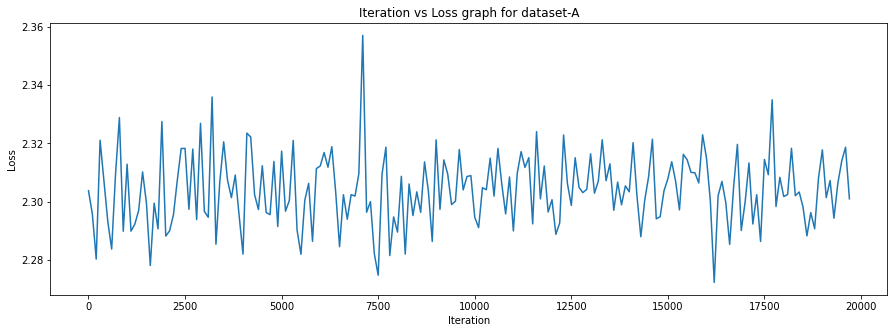

In [ ]:
iter_range=np.arange(0,19800,100)
plt.figure(figsize=(15,5))
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Iteration vs Loss graph for dataset-A')
plt.plot(iter_range,iter_loss_ds1);

### Evaluation model on 2nd dataset
> To skip the preprocessing steps, you can run from **`Load the preprocessed train and test set of dataset-2 from drive`** cell as the preprocessed data is saved to drive after being preprocessed.

### Unzip the zip file to drive

In [ ]:
!unzip '/content/drive/MyDrive/Soft Computing Lab/Dataset_2.zip' -d '/content/drive/MyDrive/Soft Computing Lab'

Archive:  /content/drive/MyDrive/Soft Computing Lab/Dataset_2.zip
   creating: /content/drive/MyDrive/Soft Computing Lab/Dataset_2/
  inflating: /content/drive/MyDrive/Soft Computing Lab/Dataset_2/t10k-images-idx3-ubyte  
  inflating: /content/drive/MyDrive/Soft Computing Lab/Dataset_2/t10k-labels-idx1-ubyte  
  inflating: /content/drive/MyDrive/Soft Computing Lab/Dataset_2/train-images-idx3-ubyte  
  inflating: /content/drive/MyDrive/Soft Computing Lab/Dataset_2/train-labels-idx1-ubyte  
  inflating: /content/drive/MyDrive/Soft Computing Lab/Dataset_2/verification_test.csv  
  inflating: /content/drive/MyDrive/Soft Computing Lab/Dataset_2/verification_train.csv  


### training and test sets

In [ ]:
train_set_ds2=pd.read_csv('/content/drive/MyDrive/Soft Computing Lab/Dataset_2/verification_train.csv')
test_set_ds2=pd.read_csv('/content/drive/MyDrive/Soft Computing Lab/Dataset_2/verification_test.csv')

In [ ]:
train_set_ds2.iloc[:,1:]=train_set_ds2.iloc[:,1:]/255.
test_set_ds2.iloc[:,1:]=test_set_ds2.iloc[:,1:]/255.

In [ ]:
def get_train_test_sets(train_set2,test_set2):
  train_ds2=[]
  test_ds2=[]
  test_len=len(test_set2)
  for i in range(len(train_set2)):
    if (i<test_len):
      test_ds2.append((torch.tensor([test_set2[i][1:].reshape(28,28)],dtype=torch.float32),int(test_set2[i][0])))
    train_ds2.append((torch.tensor([train_set2[i][1:].reshape(28,28)],dtype=torch.float32),int(train_set2[i][0])))
  return train_ds2,test_ds2

In [ ]:
trainset_ds2,testset_ds2=get_train_test_sets(train_set_ds2.values,test_set_ds2.values)

### Save the train and test set for dataset-2 to drive

In [ ]:
torch.save(trainset_ds2, '/content/drive/MyDrive/Soft Computing Lab/training_set_2.pt')
torch.save(testset_ds2, '/content/drive/MyDrive/Soft Computing Lab/testing_set_2.pt')

### Load the preprocessed train and test set of `dataset-2` from drive

In [ ]:
train_set_ds2=torch.load('/content/drive/MyDrive/Soft Computing Lab/training_set_2.pt')
test_set_ds2=torch.load('/content/drive/MyDrive/Soft Computing Lab/testing_set_2.pt')
train_set_ds2[0][0].shape,test_set_ds2[0][0].shape

(torch.Size([1, 28, 28]), torch.Size([1, 28, 28]))

### Evaluate model on `Dataset 2`

In [ ]:
g = torch.Generator()
g.manual_seed(42)
model_ds2 = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = num_hidden)
model_ds2.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_ds2.parameters(), lr=learning_rate)

train_loader_ds2 = torch.utils.data.DataLoader(dataset=train_set_ds2, 
                                           batch_size=batch_size, 
                                           shuffle=True,
                                           generator=g)

test_loader_ds2 = torch.utils.data.DataLoader(dataset=test_set_ds2, 
                                          batch_size=batch_size, 
                                          shuffle=False)

num_epochs_ds2 = num_iters / (len(train_set_ds2) / batch_size)
num_epochs_ds2 = int(num_epochs_ds2)
iter_loss_ds2=evaluate_model(model_ds2,train_loader_ds2,test_loader_ds2,num_epochs_ds2)

Epoch 1
-------------------------------
Iteration: 0. Loss: 2.294822931289673. Accuracy: 10.0
Iteration: 100. Loss: 1.2518231868743896. Accuracy: 47.87
Iteration: 200. Loss: 1.4215106964111328. Accuracy: 59.75
Iteration: 300. Loss: 0.8081918954849243. Accuracy: 63.46
Iteration: 400. Loss: 1.2497600317001343. Accuracy: 58.83
Iteration: 500. Loss: 1.0145384073257446. Accuracy: 62.48
Iteration: 600. Loss: 0.8800406455993652. Accuracy: 66.5
Iteration: 700. Loss: 0.9000247716903687. Accuracy: 55.88
Iteration: 800. Loss: 0.9684783220291138. Accuracy: 67.46
Iteration: 900. Loss: 0.8262254595756531. Accuracy: 63.97
Iteration: 1000. Loss: 0.44801074266433716. Accuracy: 65.9
Iteration: 1100. Loss: 0.9228228330612183. Accuracy: 66.39
Iteration: 1200. Loss: 1.053407907485962. Accuracy: 62.35
Iteration: 1300. Loss: 0.7885038256645203. Accuracy: 70.96
Iteration: 1400. Loss: 1.2232697010040283. Accuracy: 61.61
Iteration: 1500. Loss: 0.8778988718986511. Accuracy: 67.54
Iteration: 1600. Loss: 0.4584638

### Plot Loss vs Iteration graph for `Dataset-2`

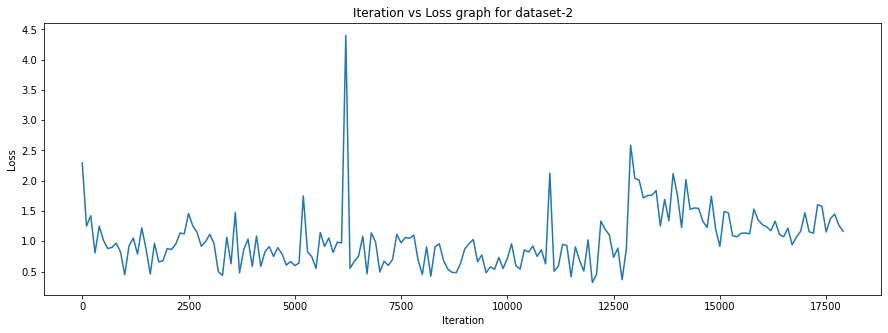

In [ ]:
iter_range=np.arange(0,18000,100)
plt.figure(figsize=(15,5))
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Iteration vs Loss graph for dataset-2')
plt.plot(iter_range,iter_loss_ds2);

In [ ]:
print(model_ds2)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=784, out_features=200, bias=True)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=200, out_features=200, bias=True)
  (relu_2): ReLU()
  (linear_3): Linear(in_features=200, out_features=200, bias=True)
  (relu_3): ReLU()
  (linear_4): Linear(in_features=200, out_features=200, bias=True)
  (relu_4): ReLU()
  (linear_5): Linear(in_features=200, out_features=200, bias=True)
  (relu_5): ReLU()
  (linear_6): Linear(in_features=200, out_features=200, bias=True)
  (relu_6): ReLU()
  (linear_out): Linear(in_features=200, out_features=10, bias=True)
)


In [ ]:
torch.save(model_ds2.state_dict(), '/content/drive/MyDrive/Soft Computing Lab/model_exp1_ds_2.pt')